This notebook investigates the stability of the learned test location. We consider the case where P is a Gaussian mixture with two components, one of which has very small mixing proporiton, and the second component has a much larger weight. Here Q is a standard Gaussian whose mass strongly overlaps with the second component of P. 

The idea is that if the sample size n is low, we will have very few to no points from the first component of P, and the learned location will be at the second component. If n is high, the learned location will be at the first component since the difference is larger.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'
import freqopttest.util as util
import freqopttest.data as data
import freqopttest.ex.exglobal as exglo
import freqopttest.kernel as kernel
import freqopttest.tst as tst
import freqopttest.glo as glo
import freqopttest.plot as plot
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import sys

In [2]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)

In [3]:
class SS2GMM(data.SampleSource):
    """
    P: N(0, I)
    Q: w*N(qmean, 0.5*I) + (1-w)*N(0, I)
    """
    def __init__(self, d, w, qmean):
        """
        d: dimension of the data 
        qmean: d-dimensional vector
        """
        if not (w>=0 and w<=1):
            raise RuntimeError('w must be in [0, 1]')
        self.d = d        
        self.w = w
        self.qmean = qmean

    def dim(self):
        return self.d

    def sample(self, n, seed):
        rstate = np.random.get_state()
        np.random.seed(seed)
        
        w = self.w
        d = self.d
        qmean = self.qmean
        disc_var = stats.rv_discrete(values=([0, 1], [w, 1-w]) )
        ind = disc_var.rvs(size=n)
        
        #y = np.zeros((n, d))
        ind0 = ind==0
        #print ind0
        ind1 = ind==1
        # draw from Q
        y1 = stats.multivariate_normal.rvs(mean=qmean, cov=0.5*np.eye(d), size=np.sum(ind0))
        y2 = stats.multivariate_normal.rvs(mean=np.zeros(d), cov=np.eye(d), size=np.sum(ind1))
        if d == 1:
            y = np.hstack((y1, y2))
            y = y[:, np.newaxis]
        else:
            y = np.vstack((y1, y2))
                
        """
        if np.isscalar(y1):
            y1 = np.array([y1])
        if np.isscalar(y2):
            y2 = np.array([y2])
        if d==1:            
            if np.any(ind0):
                y1 = y1[:, np.newaxis]
            if np.any(ind1):
                y2 = y2[:, np.newaxis]
        y[ind0, :] = y1
        y[ind1, :] = y2
        """
        
        # draw from P
        x = stats.multivariate_normal.rvs(mean=np.zeros(d), cov=np.eye(d), size=n)
        if d==1:
            x = x[:, np.newaxis]
        np.random.set_state(rstate)
        return data.TSTData(x, y, label='2gmm_d%d'%self.d)


In [26]:
# sample source 
n = 2000
alpha = 0.01
d = 1
w = 0.2
seed = 39
rep = 1
qmean = np.hstack((-5, np.zeros(d-1)))
ss = SS2GMM(d, w, qmean)

In [27]:
tst_data = ss.sample(n, seed=seed)
tr = ss.sample(n/2, seed=seed)
te = ss.sample(n/2, seed=seed+1)
#tr, te = tst_data.split_tr_te(tr_proportion=0.5, seed=10)
nte = te.X.shape[0]

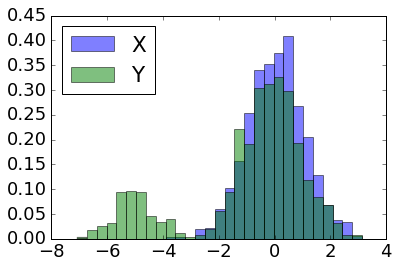

In [28]:
xtr, ytr = tr.xy()
xytr = tr.stack_xy()
bins = np.linspace(np.min(xytr), np.max(xytr), 30)
plt.hist(xtr, bins, label='X', normed=True, alpha=0.5)
plt.hist(ytr, bins, label='Y', normed=True, alpha=0.5)
plt.legend(loc='best')

In [6]:
# repeat many trials to see the value of the optimized location
locs = np.zeros(rep)
rejs = np.zeros(rep)
for r in range(rep):    
    #tst_data = ss.sample(n, seed=r)
    #tr, te = tst_data.split_tr_te(tr_proportion=0.5, seed=10)
    tr = ss.sample(n/2, seed=r)
    te = ss.sample(n/2, seed=r+1)
    # optimize the test locations and Gaussian width
    op = {'max_iter': 200, 'batch_proportion': 1.0, 'T_step_size': 2.0, 
          'gwidth_step_size': 0.5, 'tol_fun': 1e-3}
    # optimize on the training set
    #T0 = np.zeros(d)[np.newaxis, :]
    T0 = np.hstack((qmean[0]/2.0, np.zeros(d-1)))[np.newaxis, :]
    #T0 = np.hstack((qmean[0], np.zeros(d-1)))[np.newaxis, :]

    gwidth0 = util.meddistance(tr.stack_xy())**2
    test_locs, gwidth, info = tst.optimize_T_gaussian_width(
        tr, T0, gwidth0, tst.MeanEmbeddingTest.construct_z_theano, **op)
    print r
    locs[r] = test_locs[0, 0]
    
    # actual test 
    met = tst.MeanEmbeddingTest(test_locs, gwidth, alpha)
    result = met.perform_test(te)
    rejs[r] = result['h0_rejected']

0


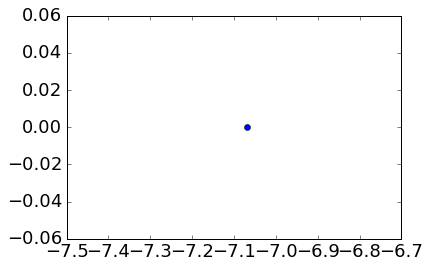

In [7]:
plt.plot(locs, rejs, 'o')

In [8]:
thresh = qmean[0]/2
print '#times loc < thresh = %.3f: %d/%d'%(thresh, np.sum(locs<qmean[0]/2), rep )
print 'overall power: %.3f'%np.mean(rejs)
n_left = np.sum(locs<thresh)
n_right = np.sum(locs>thresh)
left_rej = np.sum(rejs[locs<thresh])
right_rej = np.sum(rejs[locs>thresh])
print '#rejs with loc < thresh: %d/%d. power: %.3f'%(left_rej, n_left, left_rej/n_left)
print '#rejs with loc > thresh: %d/%d. power: %.3f'%(right_rej, n_right, right_rej/n_right)



#times loc < thresh = -2.500: 1/1
overall power: 0.000
#rejs with loc < thresh: 0/1. power: 0.000
#rejs with loc > thresh: 0/0. power: nan


In [9]:
# optimize the test locations and Gaussian width
op = {'max_iter': 400, 'batch_proportion': 1.0, 'T_step_size': 4.0, 
      'gwidth_step_size': 0.5, 'tol_fun': 1e-4}
# optimize on the training set
#T0 = np.zeros(d)[np.newaxis, :]
T0 = np.hstack((qmean[0]/2.0, np.zeros(d-1)))[np.newaxis, :]
#T0 = np.hstack((qmean[0], np.zeros(d-1)))[np.newaxis, :]

gwidth0 = util.meddistance(tr.stack_xy())**2
test_locs, gwidth, info = tst.optimize_T_gaussian_width(
    tr, T0, gwidth0, tst.MeanEmbeddingTest.construct_z_theano, **op)
#test_locs, gwidth, info = tst.MeanEmbeddingTest.optimize_locs_width(tr, alpha, **op)

In [10]:
test_locs

array([[-11.6378282]])

In [11]:
me = tst.MeanEmbeddingTest(test_locs, gwidth, alpha)
me.perform_test(te)

{'alpha': 0.01,
 'h0_rejected': False,
 'pvalue': 0.31731050786291404,
 'test_stat': 1.0}

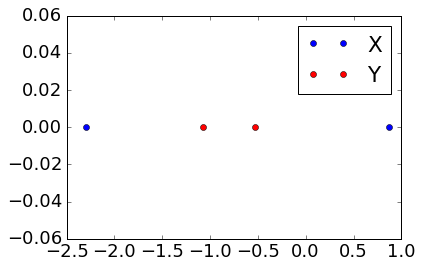

In [12]:
# plot testing data
xte, yte = te.xy()
if d>1:
    plt.plot(xte[:, 0], xte[:, 1], 'ob')
    plt.plot(yte[:, 0], yte[:, 1], 'or')
else:
    plt.plot(xte[:, 0], np.zeros(nte), 'ob', label='X')
    plt.plot(yte[:, 0], np.zeros(nte), 'or', label='Y')
    plt.legend()


## Checking the criterion

Here we fix the test location to either on the left or the right bump and compare the objective function value.

In [13]:
# sample source 
nte = 300
alpha = 0.01
d = 1
w = 0.01
seed = 39
rep = 200
qmean = np.hstack((-5, np.zeros(d-1)))
ss = SS2GMM(d, w, qmean)


In [14]:
# repeat many trials to see the value of the optimized location
def two_locations_test_results(nte):
    Tp_results = []
    Tq_results = []
    shift_seed = 800
    for r in range(shift_seed, shift_seed+rep):    
        #tst_data = ss.sample(n, seed=r)
        #tr, te = tst_data.split_tr_te(tr_proportion=0.5, seed=10)
        te = ss.sample(nte, seed=r+1)

        Tq = np.hstack((qmean[0], np.zeros(d-1)))[np.newaxis, :]
        Tp = np.hstack((0, np.zeros(d-1)))[np.newaxis, :]

        gwidth0 = util.meddistance(tr.stack_xy(), subsample=1000)**2

        # actual test 
        q_met = tst.MeanEmbeddingTest(Tq, gwidth, alpha)
        Tq_results.append(q_met.perform_test(te))
        p_met = tst.MeanEmbeddingTest(Tp, gwidth, alpha)
        Tp_results.append(p_met.perform_test(te))
    return Tp_results, Tq_results

def prob_tq_better(nte):
    Tp_results, Tq_results = two_locations_test_results(nte)
    tp_lambs = np.array([r['test_stat'] for r in Tp_results ])
    tq_lambs = np.array([r['test_stat'] for r in Tq_results ])
    n_left_high = np.sum(tq_lambs>tp_lambs)
    return float(n_left_high)/rep

In [15]:
Tp_results, Tq_results = two_locations_test_results(nte)
tp_lambs = np.array([r['test_stat'] for r in Tp_results ])
tq_lambs = np.array([r['test_stat'] for r in Tq_results ])

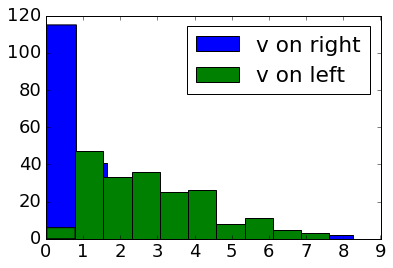

In [16]:
plt.hist(tp_lambs, label='v on right')
plt.hist(tq_lambs, label='v on left')
plt.legend()

In [17]:
n_left_high = np.sum(tq_lambs>tp_lambs)
print '#trials where left higher: %d/%d (%.2f%%)'%(n_left_high, rep, 100*float(n_left_high)/rep)
print 'std of left lambs: %.3f'%(np.std(tq_lambs))
print 'std of right lambs: %.3f'%(np.std(tp_lambs))

#trials where left higher: 162/200 (81.00%)
std of left lambs: 1.618
std of right lambs: 1.376


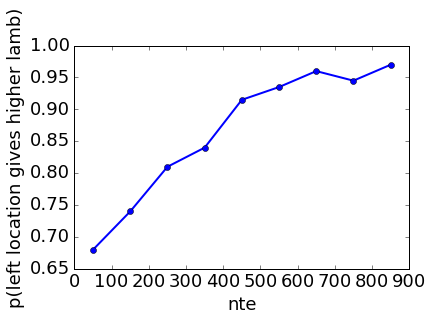

In [18]:
ntes = np.linspace(50, 850, num=9, dtype=np.int64)
ps_left_better = [prob_tq_better(nte) for nte in ntes]

plt.plot(ntes, ps_left_better, 'ob-')
plt.xlabel('nte')
plt.ylabel('p(left location gives higher lamb)')

In [19]:
np.vstack((ntes, ps_left_better))[:, 5]

array([ 550.   ,    0.935])

In [20]:
ntes

array([ 50, 150, 250, 350, 450, 550, 650, 750, 850])